In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

In [2]:
# TODO: Iterate over the whole file
# Options:
# Do it with pyarrow slice by slice
parquet_file = "all_yellow_tripdata.parquet"
parquet_reader = pq.ParquetFile(parquet_file)


In [3]:
# Remove unwanted columns
table = pq.read_table(parquet_file)
filtered_table = table.drop(['VendorID', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'])
pq.write_table(filtered_table, "all_yellow_tripdata_filtered.parquet")

In [2]:
parquet_file = "all_yellow_tripdata_filtered.parquet"
parquet_reader = pq.ParquetFile(parquet_file)

In [3]:
table = pq.read_table(parquet_file)
df = table.to_pandas()


In [4]:
num_rows = parquet_reader.metadata.num_rows
num_row_groups = parquet_reader.num_row_groups
df.shape[0]

118425410

In [5]:
print("Number of rows:", num_rows)
print("Number of cols:", df.shape[1])
print("Data types:") 
print(df.dtypes)

Number of rows: 118425410
Number of cols: 5
Data types:
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
PULocationID                      int64
DOLocationID                      int64
dtype: object


In [6]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,142,43
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,238,151
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,132,165
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,138,132
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,68,33


To save space, drop unneeded columns before analysis

In [7]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'PULocationID', 'DOLocationID'],
      dtype='object')

In [8]:
print("Number of duplicate rows:", df[df.duplicated()==True].shape[0])

Number of duplicate rows: 784764


In [9]:
category_columns = ['PULocationID', 'DOLocationID']
for column in category_columns:
    df[column] = df[column].astype('category')

In [10]:
# Numeric
numeric_columns = df.select_dtypes(['int64', 'float64', 'datetime64']).columns

In [11]:
# Get cardinality of the numeric columns
numeric_columns_card = df[numeric_columns].nunique()
df_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])
df_numeric_card

,card
tpep_pickup_datetime,61065577
tpep_dropoff_datetime,61029171
passenger_count,12


In [12]:
# First describe the numeric features
df_table_numeric = df[numeric_columns].describe().T
df_table_numeric

,count,mean,min,25%,50%,75%,max,std
tpep_pickup_datetime,118425410,2022-09-19 05:25:15.906606,2001-01-01 00:03:14,2021-12-16 14:09:11.250000,2022-09-22 06:41:00,2023-06-19 13:50:32.750000,2098-09-11 02:23:31,NaN
tpep_dropoff_datetime,118425410,2022-09-19 05:54:12.959122,1970-01-20 10:16:32,2021-12-16 14:28:57,2022-09-22 06:56:45,2023-06-19 14:07:41.750000,2098-09-11 02:52:04,NaN
passenger_count,113517094.0,1.392782,0.0,1.0,1.0,1.0,112.0,0.95122


In [13]:
# Add % missing
numeric_columns_missing  = 100 * (df[numeric_columns].isnull().sum()/df.shape[0])
df_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])
df_numeric_missing

,%missing
tpep_pickup_datetime,0.000000
tpep_dropoff_datetime,0.000000
passenger_count,4.144648


In [14]:
df[category_columns].nunique()

PULocationID    263
DOLocationID    262
dtype: int64

In [15]:
# Change category cols to remove 
# Look at the values taken by each categorical feature, as a proportion, including NaN
for column in category_columns:
    # print("\n" + column)
    print(df[column].value_counts(normalize=True, dropna=False))

PULocationID
237    4.765411e-02
132    4.528157e-02
236    4.301313e-02
161    4.124280e-02
186    3.325698e-02
           ...     
99     5.488687e-07
176    4.475391e-07
199    4.390950e-07
105    3.377653e-07
110    1.688827e-08
Name: proportion, Length: 263, dtype: float64
DOLocationID
236    4.424810e-02
237    4.200376e-02
161    3.622271e-02
170    2.955400e-02
239    2.805379e-02
           ...     
204    4.711827e-06
2      1.579053e-06
99     1.123070e-06
105    4.306508e-07
110    4.222067e-08
Name: proportion, Length: 262, dtype: float64


In [33]:
# One value missing for DOLoc that's in PULoc
do = set(df['DOLocationID'].unique())
pu = set(df['PULocationID'].unique())
diff = pu - do
print(diff)

{199}


In [35]:
df[df['PULocationID']==199].count()

tpep_pickup_datetime     52
tpep_dropoff_datetime    52
passenger_count          52
PULocationID             52
DOLocationID             52
dtype: int64

In [16]:
df_sample = df.sample(n=1000000)

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>],
       [<Axes: title={'center': 'passenger_count'}>, <Axes: >]],
      dtype=object)

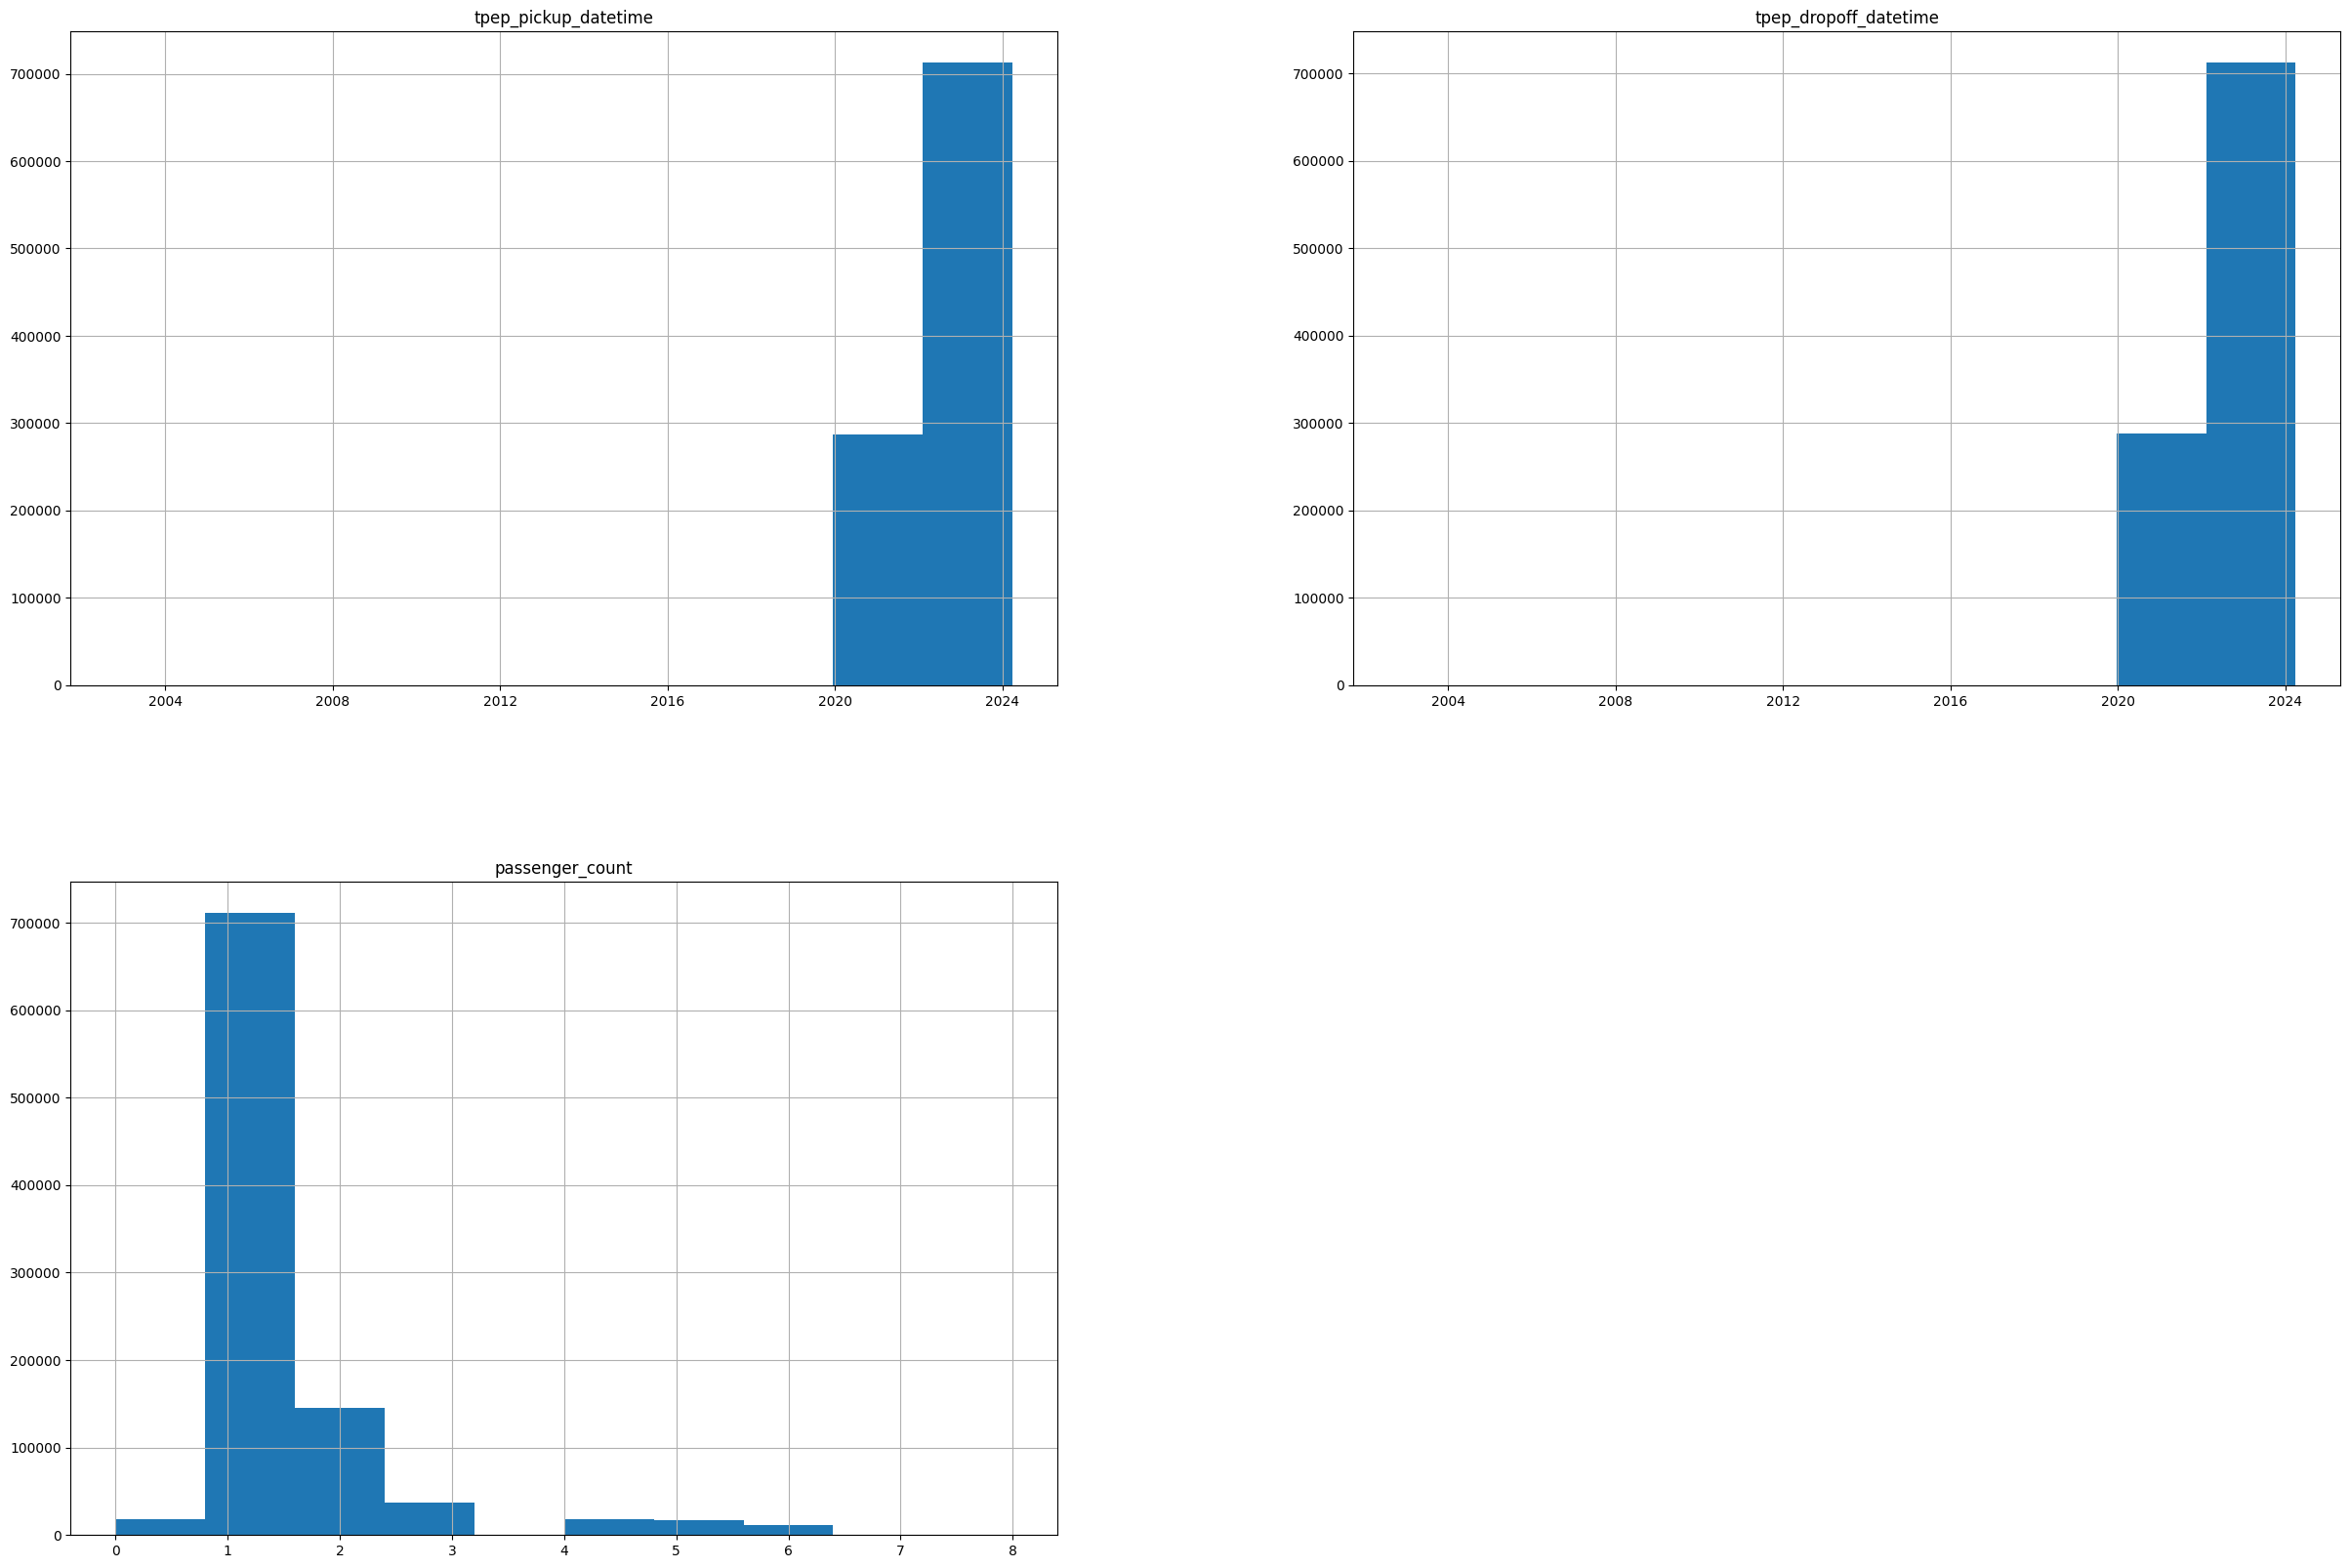

In [17]:
df_sample.hist(figsize=(30, 20))

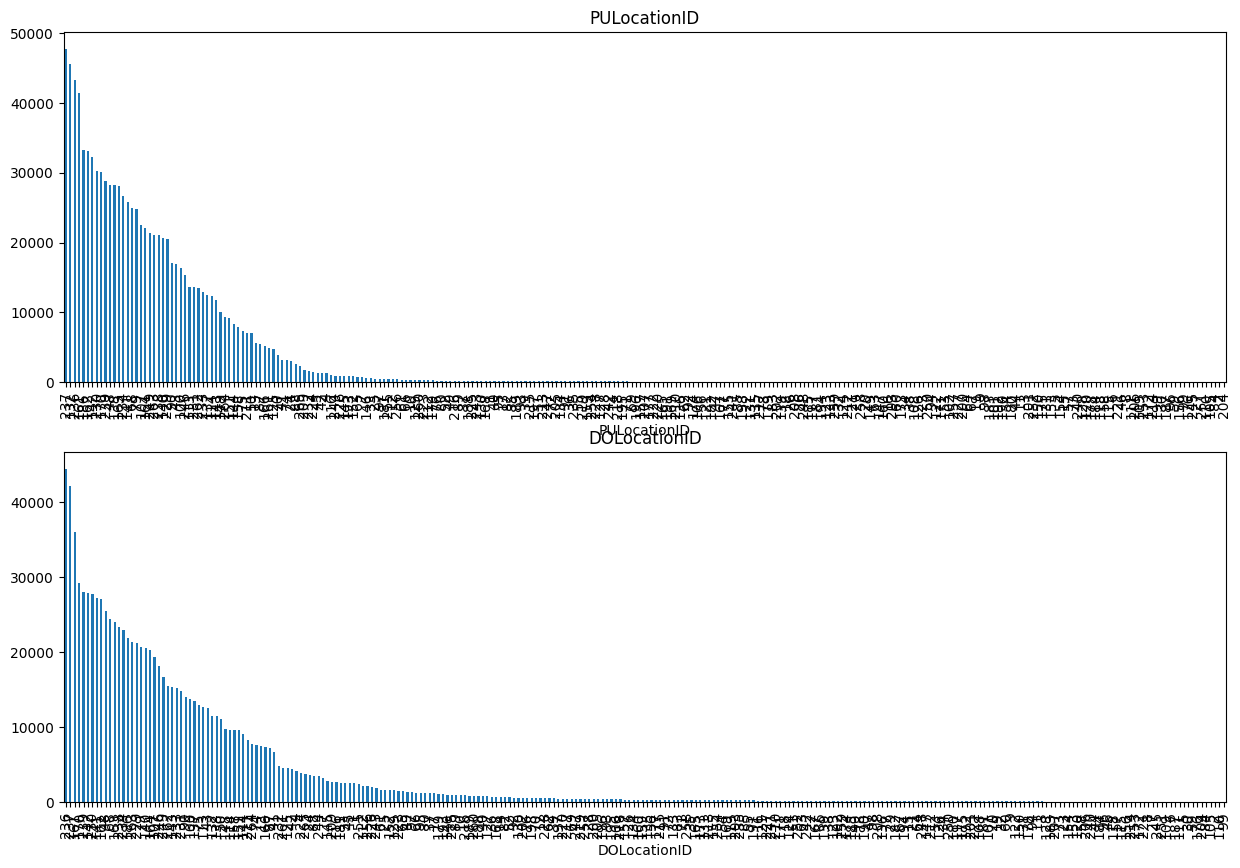

In [18]:
# Plot categoric columns
num_rows = 2

# Create a single figure with subplots arranged in a 2-column grid
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(15, 5*num_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over each column
for i, column in enumerate(category_columns):
    # Plot each bar plot on its corresponding subplot
    df_sample[column].value_counts(dropna=False).plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)

for j in range(len(category_columns), 2):
    fig.delaxes(axes[j])

plt.show()

In [19]:
# Look once again at the summary stats table for categorical features
df_table_categoric = df[category_columns].describe().T
category_columns_perc_missing  = 100 * (df[category_columns].isnull().sum()/df.shape[0])
df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
# cardinality
category_columns_card = df[category_columns].nunique()
df_category_card = pd.DataFrame(category_columns_card, columns=['card'])

In [20]:
second_val = []
second_freq = []
for category in category_columns:
    # print(df[category].value_counts().index.tolist())
    second_val.append(df[category].value_counts().index.tolist()[1])
    second_freq.append(df[category].value_counts().iloc[1])

In [21]:
# Concatenate numeric, missing and cardinality cols
df_categoric_columns_data_quality_report_table = pd.concat([df_table_categoric, df_category_perc_missing, df_category_card], axis=1)

df_categoric_columns_data_quality_report_table['second'] = second_val
df_categoric_columns_data_quality_report_table['second_freq'] = second_freq

df_categoric_columns_data_quality_report_table = df_categoric_columns_data_quality_report_table[['count', 'unique', 'top', 'freq', 'second', 'second_freq', '%missing', 'card']]
# Print data quality report table for numeric features to a file.
df_categoric_columns_data_quality_report_table.to_csv("Yellow-Taxi-DataQualityReport-CategoricFeatures-Table.csv", 
                                         index_label='Feature')
df_categoric_columns_data_quality_report_table

,count,unique,top,freq,second,second_freq,%missing,card
PULocationID,118425410,263,237,5643457,132,5362488,0.0,263
DOLocationID,118425410,262,236,5240099,237,4974312,0.0,262


In [22]:
# Concatenate numeric, missing and cardinality cols
df_numeric_columns_data_quality_report_table = pd.concat([df_table_numeric, df_numeric_missing, df_numeric_card], axis=1)

# Print data quality report table for numeric features to a file.
df_numeric_columns_data_quality_report_table.to_csv("Yellow-Taxi-DataQualityReport-NumericFeatures-Table.csv", 
                                         index_label='Feature')
df_numeric_columns_data_quality_report_table

,count,mean,min,25%,50%,75%,max,std,%missing,card
tpep_pickup_datetime,118425410,2022-09-19 05:25:15.906606,2001-01-01 00:03:14,2021-12-16 14:09:11.250000,2022-09-22 06:41:00,2023-06-19 13:50:32.750000,2098-09-11 02:23:31,NaN,0.000000,61065577
tpep_dropoff_datetime,118425410,2022-09-19 05:54:12.959122,1970-01-20 10:16:32,2021-12-16 14:28:57,2022-09-22 06:56:45,2023-06-19 14:07:41.750000,2098-09-11 02:52:04,NaN,0.000000,61029171
passenger_count,113517094.0,1.392782,0.0,1.0,1.0,1.0,112.0,0.95122,4.144648,12


### Logical integrity tests
1. dropoff not before pickup
2. Passenger count not negative
3. Passenger count not greater than 6
4. Pickup date before 2021
5. Dropoff date > 31st Mar 2024
6. Duration of taxi ride > 5hrs
7. PU location ID not an allowed value
8. DO location ID not an allowed value



In [23]:
# Test 1: 
df[df['tpep_dropoff_datetime']<df['tpep_pickup_datetime']]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
151936,2021-01-05 17:43:19,2021-01-05 17:39:06,1.0,145,145
556110,2021-01-15 07:27:40,2020-10-13 12:03:02,1.0,161,234
1271424,2021-01-01 00:01:06,2021-01-01 00:01:02,NaN,265,108
1271441,2021-01-01 00:01:14,2021-01-01 00:01:02,NaN,265,69
1271464,2021-01-01 00:01:08,2021-01-01 00:01:03,NaN,265,35
...,...,...,...,...,...
118416669,2024-03-31 10:03:31,2024-03-31 10:03:14,NaN,265,28
118416670,2024-03-31 10:03:52,2024-03-31 10:03:36,NaN,265,28
118418349,2024-03-31 13:03:18,2024-03-31 13:03:07,NaN,265,89
118418613,2024-03-31 13:03:51,2024-03-31 13:03:34,NaN,265,148


In [24]:
# Test 2:
df[df['passenger_count']<0]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID


In [25]:
# Test 3:
df[df['passenger_count']>6]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
22184,2021-01-01 21:56:36,2021-01-01 22:01:54,8.0,79,148
375439,2021-01-11 08:59:14,2021-01-11 08:59:20,7.0,233,264
456953,2021-01-12 23:27:43,2021-01-12 23:56:13,7.0,145,265
745182,2021-01-19 19:04:57,2021-01-19 19:30:01,7.0,138,265
903506,2021-01-23 10:28:22,2021-01-23 10:49:48,7.0,100,265
...,...,...,...,...,...
116520735,2024-03-16 23:43:27,2024-03-16 23:43:30,7.0,264,264
116674682,2024-03-18 17:34:46,2024-03-18 17:35:01,7.0,100,100
116773381,2024-03-19 18:23:39,2024-03-19 18:23:51,8.0,230,230
117128279,2024-03-22 23:38:39,2024-03-22 23:38:45,7.0,255,255


In [26]:
# Test 4: 
df[df['tpep_pickup_datetime']<pd.to_datetime('2021-01-01')]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
455,2020-12-31 23:59:06,2021-01-01 00:02:51,2.0,237,236
530,2020-12-31 21:40:20,2020-12-31 22:16:09,1.0,249,213
546,2020-12-31 23:57:17,2021-01-01 00:17:40,1.0,163,166
637,2020-12-31 18:41:27,2021-01-01 17:52:03,1.0,90,229
902,2020-12-31 23:55:40,2021-01-01 00:24:51,1.0,231,17
...,...,...,...,...,...
111428688,2009-01-01 00:24:09,2009-01-01 01:13:00,2.0,138,264
112016539,2008-12-31 22:52:49,2008-12-31 23:04:09,1.0,141,211
112734109,2009-01-01 00:02:13,2009-01-01 00:48:28,1.0,79,148
116513533,2002-12-31 22:17:10,2002-12-31 22:42:24,1.0,50,162


In [31]:
# Test 5: 
df[df['tpep_dropoff_datetime']>pd.to_datetime('2024-04-01')]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
11077278,2029-05-05 08:37:39,2029-05-05 12:18:20,1.0,231,249
17463861,2070-08-29 22:12:44,2070-08-30 17:21:12,1.0,193,193
18674715,2098-09-11 02:23:31,2098-09-11 02:52:04,5.0,163,231
28450609,2028-12-07 04:48:15,2028-12-07 05:29:13,3.0,132,170
117527574,2024-03-27 10:36:13,2024-04-02 18:08:46,1.0,207,207
...,...,...,...,...,...
118425361,2024-03-31 23:50:43,2024-04-01 00:19:28,NaN,132,166
118425368,2024-03-31 23:54:57,2024-04-01 00:09:51,NaN,138,237
118425372,2024-03-31 23:47:38,2024-04-01 00:11:07,NaN,230,209
118425385,2024-03-31 23:56:27,2024-04-01 00:24:53,NaN,138,68


In [32]:
late_dropoff = df[df['tpep_dropoff_datetime']>pd.to_datetime('2024-04-01')]
late_dropoff.describe().T

,count,mean,min,25%,50%,75%,max,std
tpep_pickup_datetime,621,2024-06-16 18:32:42.165861,2024-03-27 10:36:13,2024-03-31 23:40:09,2024-03-31 23:49:23,2024-03-31 23:55:37,2098-09-11 02:23:31,NaN
tpep_dropoff_datetime,621,2024-06-16 21:56:36.544283,2024-04-01 00:00:07,2024-04-01 00:05:17,2024-04-01 00:11:27,2024-04-01 00:22:02,2098-09-11 02:52:04,NaN
passenger_count,600.0,1.32,0.0,1.0,1.0,1.0,6.0,0.831918


In [28]:
# Test 6:
time_diff = pd.Timedelta(hours=5)
df[df['tpep_dropoff_datetime']-df['tpep_pickup_datetime'] > time_diff]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
634,2021-01-01 00:12:57,2021-01-01 23:27:19,1.0,260,223
637,2020-12-31 18:41:27,2021-01-01 17:52:03,1.0,90,229
907,2021-01-01 00:37:24,2021-01-01 23:55:37,1.0,161,142
991,2021-01-01 00:54:24,2021-01-02 00:51:23,2.0,239,68
1580,2021-01-01 01:37:49,2021-01-02 01:32:06,1.0,229,142
...,...,...,...,...,...
118212559,2024-03-17 04:20:58,2024-03-18 15:16:58,NaN,249,265
118347651,2024-03-27 21:58:00,2024-03-28 07:53:06,NaN,107,130
118369973,2024-03-28 22:00:44,2024-03-29 11:50:46,NaN,100,179
118376244,2024-03-29 05:02:00,2024-03-30 04:59:00,NaN,231,231


In [29]:
long_rides = df[df['tpep_dropoff_datetime']-df['tpep_pickup_datetime'] > time_diff]
long_rides['time_diff'] = long_rides['tpep_dropoff_datetime']-long_rides['tpep_pickup_datetime']
long_rides.describe().T

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13332\1205081319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_rides['time_diff'] = long_rides['tpep_dropoff_datetime']-long_rides['tpep_pickup_datetime']


,count,mean,min,25%,50%,75%,max,std
tpep_pickup_datetime,142475,2022-05-19 08:48:32.415939,2001-01-01 00:06:49,2021-09-10 21:39:18,2022-04-26 14:45:39,2023-01-28 20:47:01.500000,2070-08-29 22:12:44,NaN
tpep_dropoff_datetime,142475,2022-05-27 06:45:55.318813,2001-01-01 14:13:51,2021-09-12 19:17:28.500000,2022-04-28 13:05:50,2023-01-29 19:53:53.500000,2070-08-30 17:21:12,NaN
passenger_count,142136.0,1.759976,0.0,1.0,1.0,2.0,9.0,1.370765
time_diff,142475,7 days 21:57:22.902874,0 days 05:00:03,0 days 23:13:09,0 days 23:42:54,0 days 23:54:33,7168 days 02:15:11,223 days 18:06:20.027523


In [42]:
# Test 7:
taxi_lookup = pd.read_csv('taxi_zone_lookup.csv')
taxi_zones = set(taxi_lookup['LocationID'])
df[~df['PULocationID'].isin(taxi_zones)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID


In [43]:
df[~df['DOLocationID'].isin(taxi_zones)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
